Explore ISMIP6 forcing files generated on the MALI mesh. These are TF fields.

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [5]:
main_dir = Path.cwd().parent


In [2]:
forcing_basepath = "data/external/MALI_projects/ISMIP6_2300/forcing/data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/tier1_experiments/"

In [57]:
UKESM_ssp126 = xr.open_dataset(main_dir / "data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/tier1_experiments/expAE10/AIS_4to20km_TF_UKESM1-0-LL_SSP126_2300.nc", chunks={"Time":36})
UKESM_ssp585 = xr.open_dataset(main_dir / "data/external/MALI_projects/ISMIP6_2300/forcing/ais_mesh_4to20km_res/tier1_experiments/expAE05/AIS_4to20km_r01_20220907_TF_UKESM1-0-LL_SSP585_2300.nc", chunks={"Time":36})


In [58]:
UKESM_ssp126_ts = UKESM_ssp126.mean(dim=["nCells", "nISMIP6OceanLayers"]).compute()
UKESM_ssp585_ts = UKESM_ssp585.mean(dim=["nCells", "nISMIP6OceanLayers"]).compute()

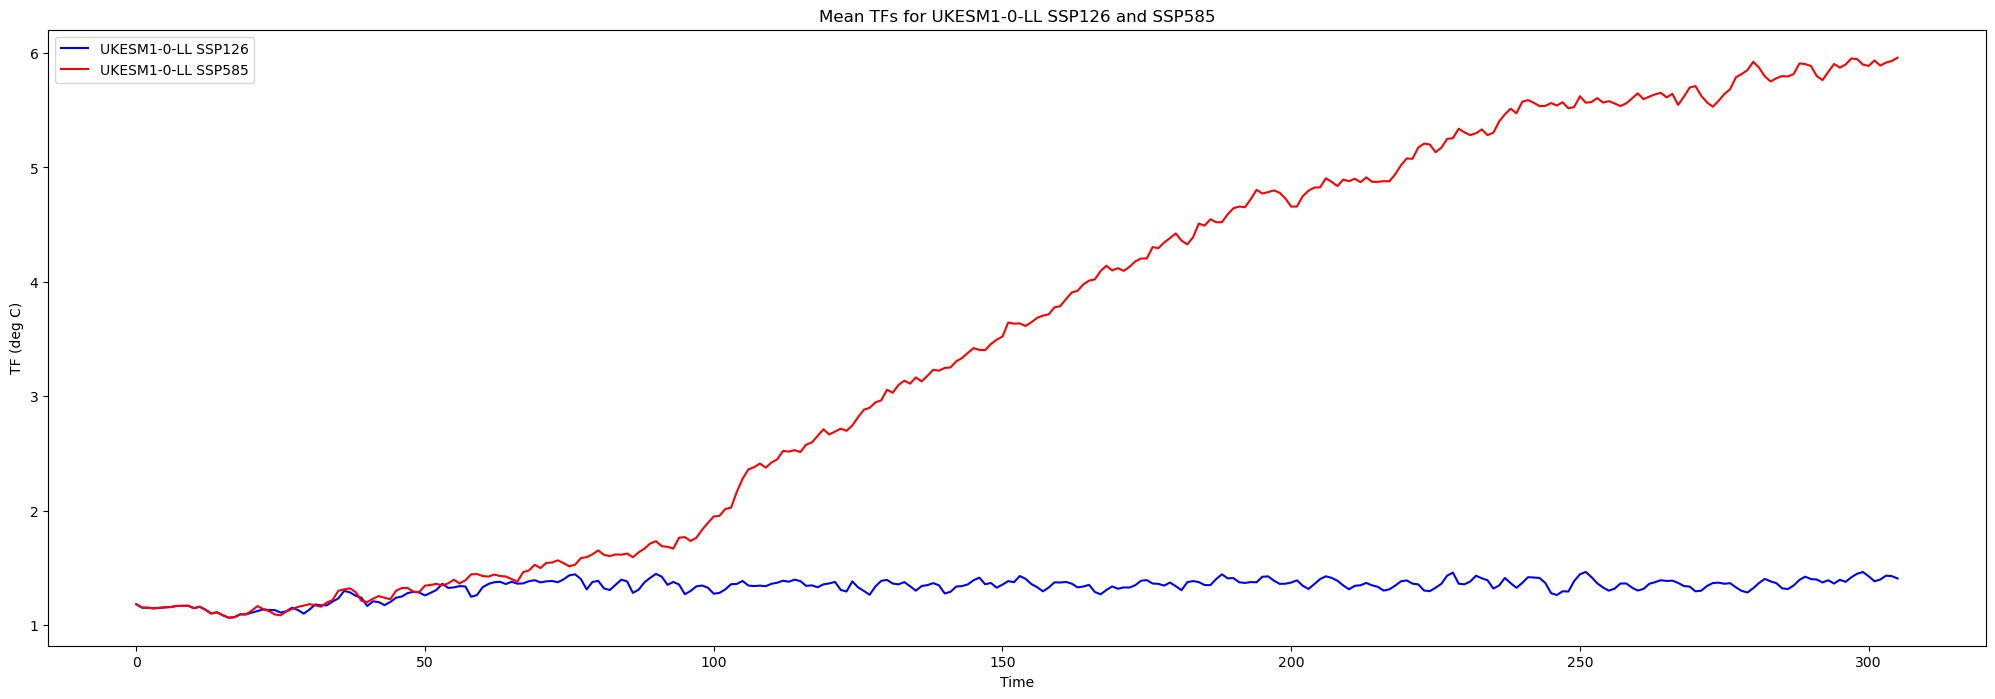

In [59]:
# Plot UKESM ssp126 and ssp585 mean TFs

fig, ax = plt.subplots(figsize=(25, 8))
UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="blue", label="UKESM1-0-LL SSP126")
UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="red", label="UKESM1-0-LL SSP585")
ax.set_title("Mean TFs for UKESM1-0-LL SSP126 and SSP585")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()


In [47]:
def detrend_dim(data, dim, deg):
    # Store the original mean
    original_mean = data.mean(dim=dim).compute()

    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg).compute()
    fit = xr.polyval(data[dim], p.polyfit_coefficients).compute()
    detrended = data - fit

    # Add back the original mean
    # detrended += original_mean

    return detrended

In [60]:
UKESM_ssp126_ts_detrended = detrend_dim(UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing, dim="Time", deg=1)
UKESM_ssp585_ts_detrended = detrend_dim(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing, dim="Time", deg=1)

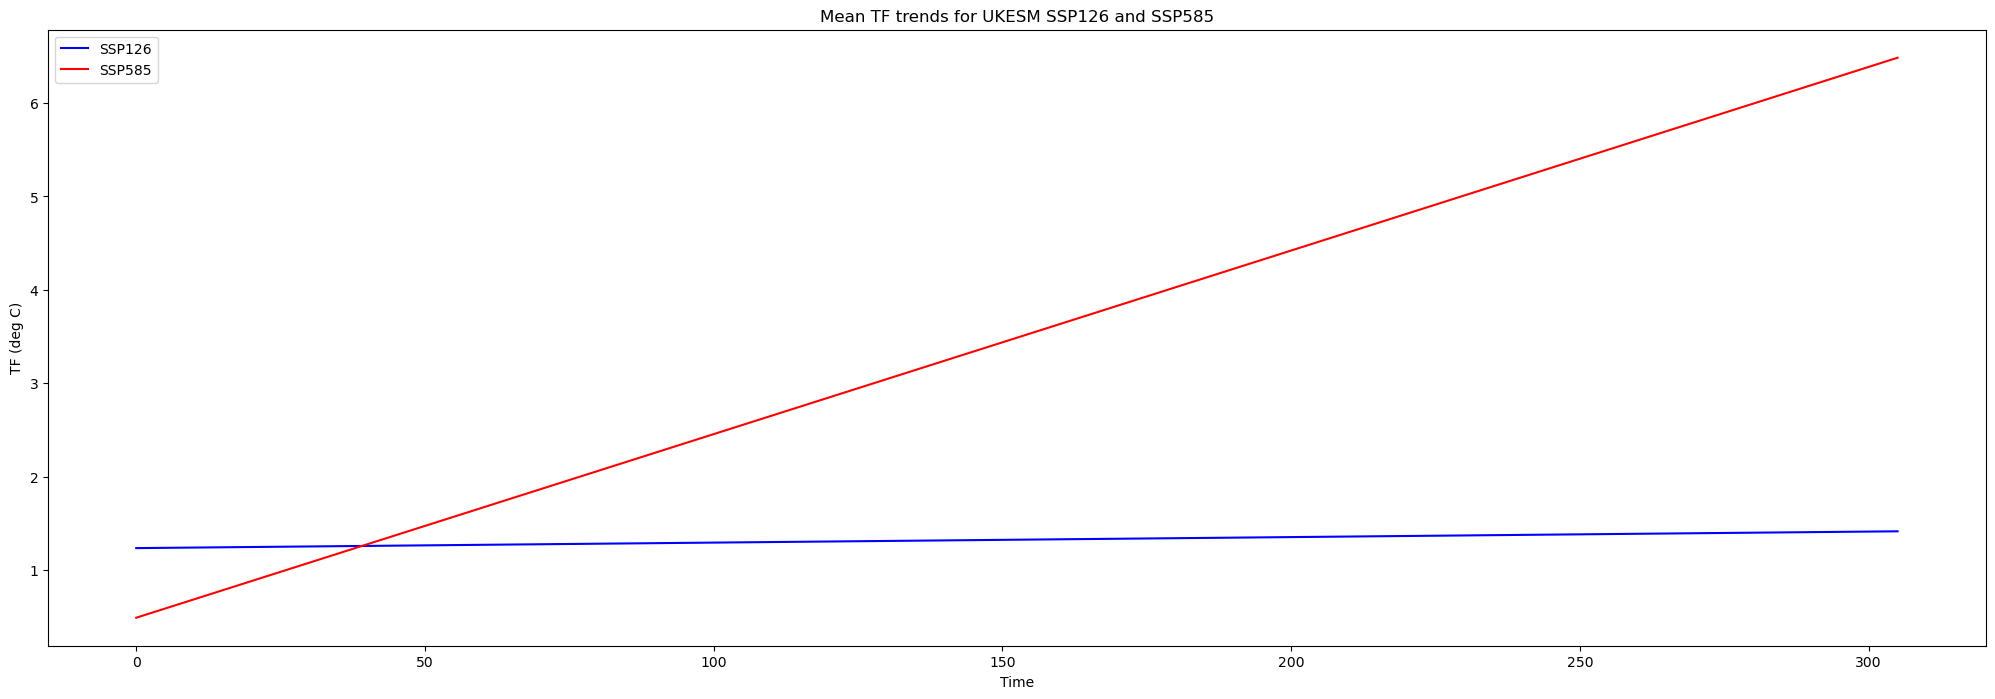

In [64]:
fig, ax = plt.subplots(figsize=(25, 8))
(UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp126_ts_detrended).plot(ax=ax, color="blue", label="SSP126")
(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp585_ts_detrended).plot(ax=ax, color="red", label="SSP585")
ax.set_title("Mean TF trends for UKESM SSP126 and SSP585")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()

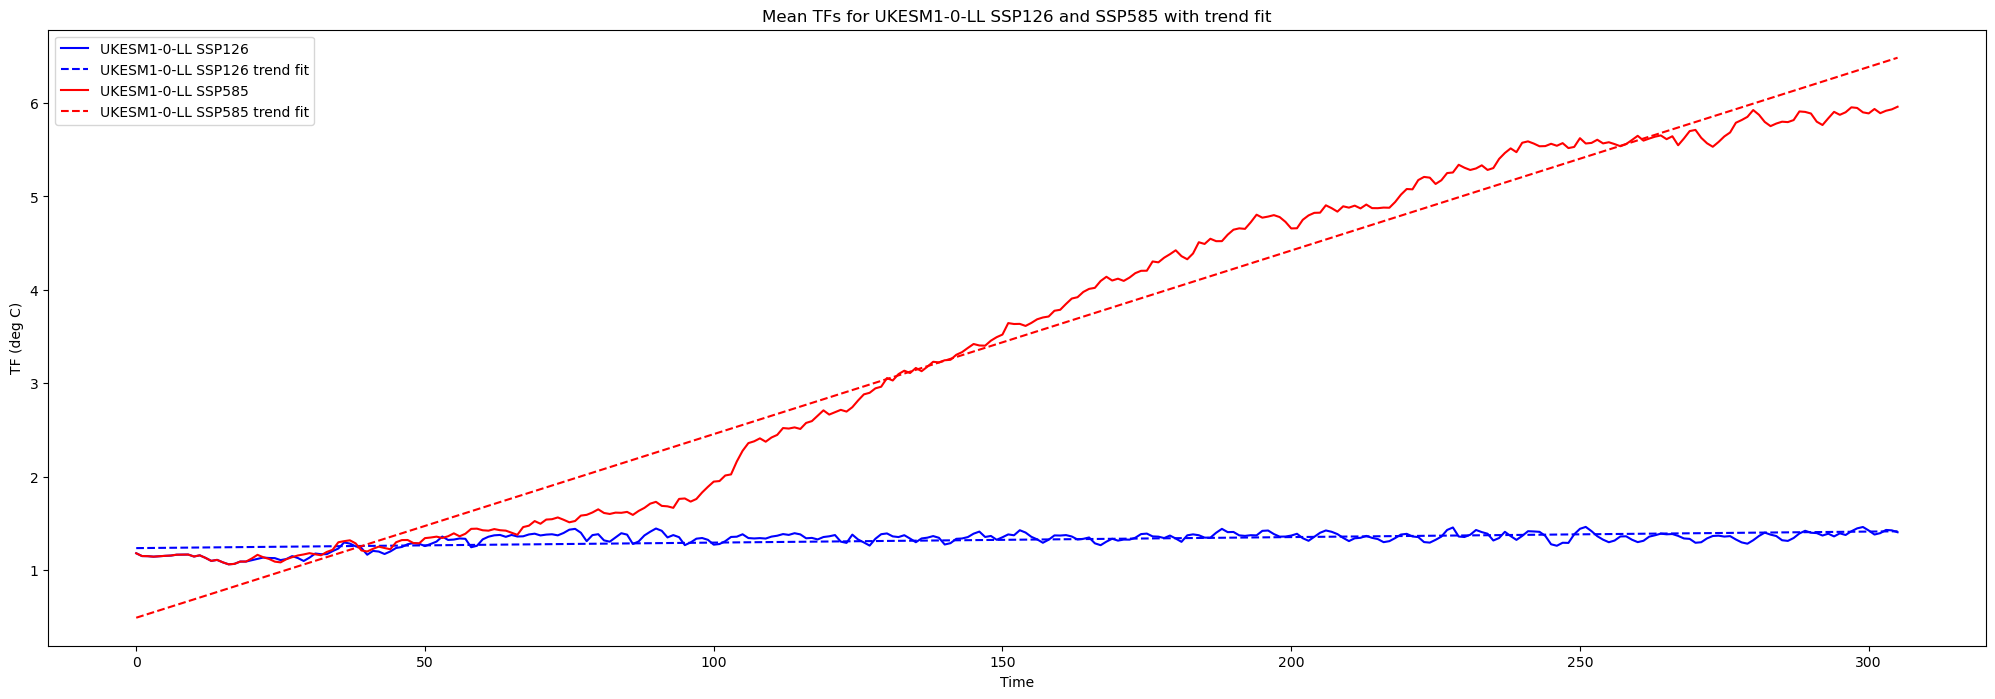

In [66]:
# Plot UKESM ssp126 and ssp585 mean TFs with trend fit
fig, ax = plt.subplots(figsize=(25, 8))
UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="blue", label="UKESM1-0-LL SSP126")
(UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp126_ts_detrended).plot(ax=ax, color="blue", linestyle="--", label="UKESM1-0-LL SSP126 trend fit")
UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="red", label="UKESM1-0-LL SSP585")
(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp585_ts_detrended).plot(ax=ax, color="red", linestyle="--", label="UKESM1-0-LL SSP585 trend fit")
ax.set_title("Mean TFs for UKESM1-0-LL SSP126 and SSP585 with trend fit")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()
plt.show()

In [67]:
# TODO: Breakpoint fits for the trend components

import ruptures as rpt


In [68]:
def detrend_with_breakpoints(data, dim, deg=1, model="linear", penalty=10):
    """
    Automatically detrend data with breakpoints based on changes in the slope.

    Parameters:
        data (xarray.DataArray): The input data to detrend.
        dim (str): The dimension along which to detrend.
        deg (int): The degree of the polynomial fit (default is 1 for linear).
        model (str): The model for change point detection (default is "linear").
        penalty (int): The penalty value for the change point detection algorithm.

    Returns:
        xarray.DataArray: The detrended data with breakpoints applied.
    """
    # Extract the data and dimension values as numpy arrays
    time = data[dim].values
    values = data.values

    # Detect breakpoints using the ruptures library
    algo = rpt.Pelt(model=model).fit(values)
    breakpoints = algo.predict(pen=penalty)

    # Initialize an array to store the detrended data
    detrended_values = np.zeros_like(values)

    # Fit and detrend each segment
    start = 0
    for end in breakpoints:
        segment = slice(start, end)
        time_segment = time[segment]
        values_segment = values[segment]

        # Fit a polynomial to the segment
        coeffs = np.polyfit(time_segment, values_segment, deg)
        fit = np.polyval(coeffs, time_segment)

        # Detrend the segment
        detrended_values[segment] = values_segment - fit

        # Update the start index for the next segment
        start = end

    # Create a new xarray.DataArray with the detrended values
    detrended_data = xr.DataArray(
        detrended_values,
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs
    )

    return detrended_data

In [105]:
import ruptures as rpt
import xarray as xr
import numpy as np

def detrend_with_breakpoints(data, dim, deg=1, model="normal", penalty=10):
    """
    Automatically detrend data with breakpoints based on changes in the slope.

    Parameters:
        data (xarray.DataArray): The input data to detrend.
        dim (str): The dimension along which to detrend.
        deg (int): The degree of the polynomial fit (default is 1 for linear).
        model (str): The cost model for change point detection (default is "l2").
        penalty (int): The penalty value for the change point detection algorithm.

    Returns:
        xarray.DataArray: The detrended data with breakpoints applied.
    """
    # Extract the data and dimension values as numpy arrays
    time = data[dim].values
    values = data.values

    # Ensure the data is 1D
    if values.ndim > 1:
        raise ValueError("Input data must be one-dimensional.")

    # Detect breakpoints using the ruptures library
    algo = rpt.Pelt(model=model).fit(values)
    breakpoints = algo.predict(pen=penalty)

    # Initialize an array to store the detrended data
    detrended_values = np.zeros_like(values)

    # Fit and detrend each segment
    start = 0
    for end in breakpoints:
        segment = slice(start, end)
        time_segment = time[segment]
        values_segment = values[segment]

        # Fit a polynomial to the segment
        coeffs = np.polyfit(time_segment, values_segment, deg)
        fit = np.polyval(coeffs, time_segment)

        # Detrend the segment
        detrended_values[segment] = values_segment - fit

        # Update the start index for the next segment
        start = end

    # Create a new xarray.DataArray with the detrended values
    detrended_data = xr.DataArray(
        detrended_values,
        dims=data.dims,
        coords=data.coords,
        attrs=data.attrs
    )

    return detrended_data

In [109]:
UKESM_ssp585_ts_detrended = detrend_with_breakpoints(
        data=UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing,
        dim="Time",
        deg=1,
        penalty=2
)

UKESM_ssp126_ts_detrended = detrend_with_breakpoints(
        data=UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing,
        dim="Time",
        deg=1,
        penalty=2
)

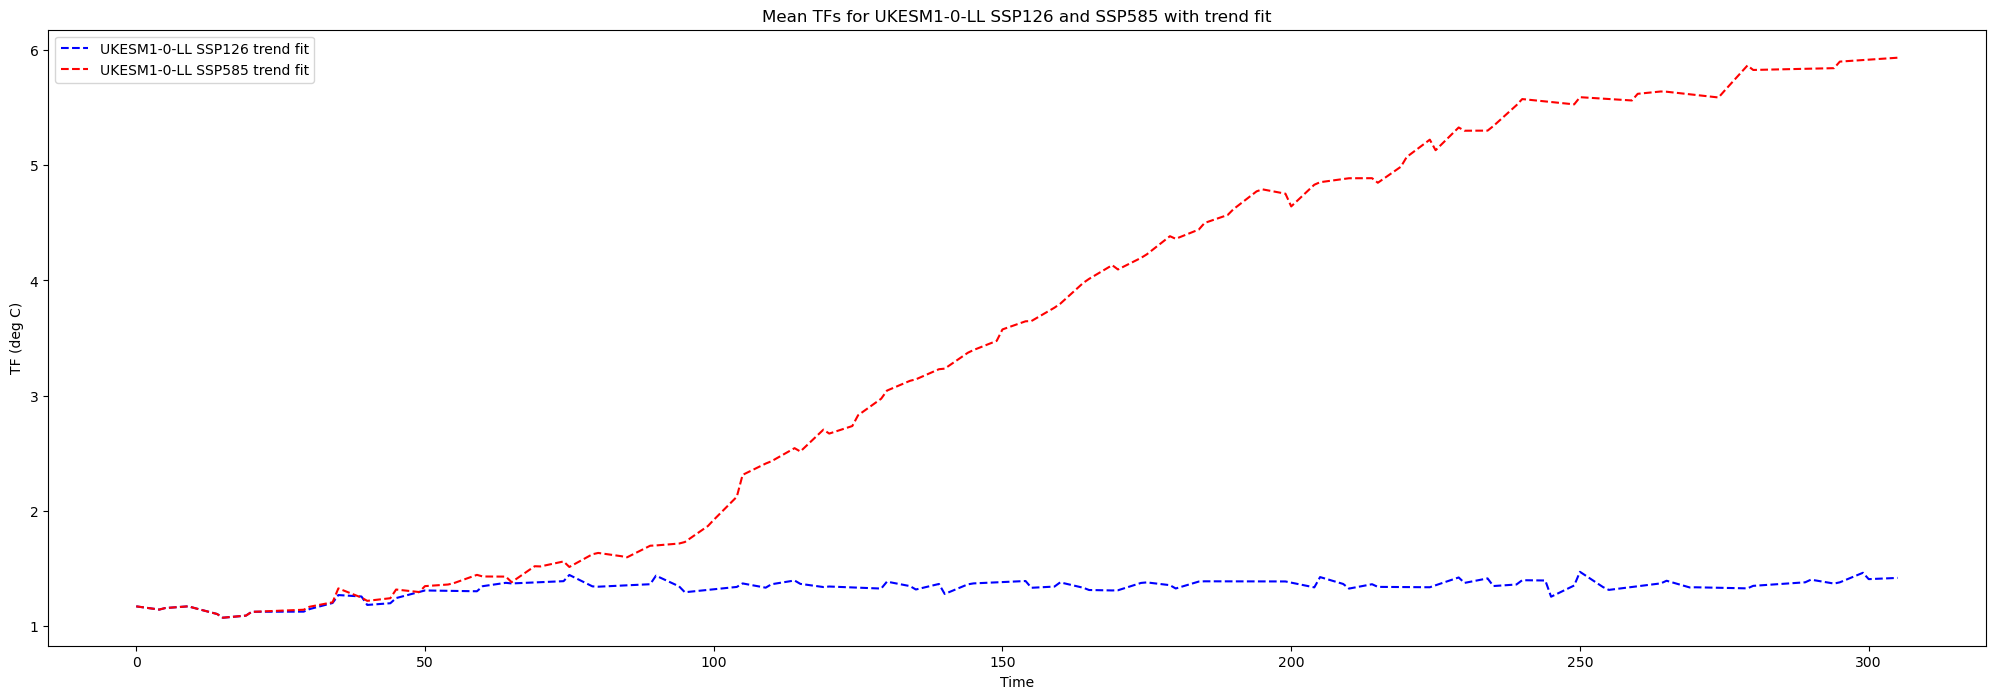

In [111]:
# Plot UKESM ssp126 and ssp585 mean TFs with break points fit
fig, ax = plt.subplots(figsize=(25, 8))
#UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="blue", label="UKESM1-0-LL SSP126")
(UKESM_ssp126_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp126_ts_detrended).plot(ax=ax, color="blue", linestyle="--", label="UKESM1-0-LL SSP126 trend fit")
#UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing.plot(ax=ax, color="red", label="UKESM1-0-LL SSP585")
(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing - UKESM_ssp585_ts_detrended).plot(ax=ax, color="red", linestyle="--", label="UKESM1-0-LL SSP585 trend fit")
ax.set_title("Mean TFs for UKESM1-0-LL SSP126 and SSP585 with trend fit")
ax.set_xlabel("Time")
ax.set_ylabel("TF (deg C)")
ax.legend()
plt.show()

In [ ]:
# Vectorized ruptures with xr.apply_ufunc.
# This is a wrapper to use ruptures with xarray
# and apply_ufunc. It uses the ruptures library to detect breakpoints
# Ref: https://github.com/deepcharles/ruptures/discussions/139
# TODO: Modify for 3D forcing datasets


In [121]:
import ruptures as rpt
import xarray as xr
import numpy as np

def detect_breakpoints(arr, model="l2", penalty=10):
    """
    Detect breakpoints in a 1D array using ruptures.
    
    Parameters:
        arr (numpy.ndarray): 1D array of input data.
        model (str): The cost model for change point detection (default is "l2").
        penalty (int): The penalty value for the change point detection algorithm.

    Returns:
        list: List of breakpoints indices.
    """
    algo = rpt.Pelt(model=model).fit(arr)
    return algo.predict(pen=penalty)

def detrend_segmented(arr, time, breakpoints, deg=1):
    """
    Detrend a 1D array segment-by-segment based on breakpoints.
    
    Parameters:
        arr (numpy.ndarray): 1D array of input data.
        time (numpy.ndarray): 1D array of time values.
        breakpoints (list): List of breakpoint indices.
        deg (int): Degree of the polynomial fit (default is 1 for linear).

    Returns:
        numpy.ndarray: Detrended array.
    """
    detrended_values = np.zeros_like(arr)
    start = 0
    for end in breakpoints:
        segment = slice(start, end)
        time_segment = time[segment]
        values_segment = arr[segment]

        # Fit a polynomial to the segment
        coeffs = np.polyfit(time_segment, values_segment, deg)
        fit = np.polyval(coeffs, time_segment)

        # Detrend the segment
        detrended_values[segment] = values_segment - fit

        # Update the start index for the next segment
        start = end

    return detrended_values

def detrend_with_breakpoints_vectorized(data, dim, deg=1, model="l2", penalty=10):
    """
    Automatically detrend an xarray.DataArray with breakpoints along a specified dimension.

    Parameters:
        data (xarray.DataArray): The input data to detrend.
        dim (str): The dimension along which to detrend.
        deg (int): The degree of the polynomial fit (default is 1 for linear).
        model (str): The cost model for change point detection (default is "l2").
        penalty (int): The penalty value for the change point detection algorithm.

    Returns:
        xarray.DataArray: The detrended data with breakpoints applied.
    """
    def _process_single_slice(arr, coord_vals):
        # Detect breakpoints using ruptures
        breakpoints = detect_breakpoints(arr, model=model, penalty=penalty)
        # Detrend the data segment by segment
        return detrend_segmented(arr, coord_vals, breakpoints, deg=deg)

    detrended_data = xr.apply_ufunc(
        _process_single_slice,
        data,
        data[dim],
        input_core_dims=[[dim], [dim]],  # Specify core dimensions
        output_core_dims=[[dim]],        # Specify output dimension
        vectorize=True,                  # Enable vectorization
        dask="parallelized",             # Allow Dask parallelization
        output_dtypes=[data.dtype]       # Ensure correct output dtype
    )

    return detrended_data

In [122]:
# Assuming the function detrend_with_breakpoints_vectorized is already defined

# Your DataArray
data_array = UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing

# Apply the detrending function along the "Time" dimension
detrended_data = detrend_with_breakpoints_vectorized(
    data_array,
    dim="Time",        # Specify the dimension to detrend
    deg=1,             # Degree of polynomial (e.g., 1 for linear detrending)
    model="normal",        # Cost model for ruptures
    penalty=10         # Penalty value for change point detection
)



/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


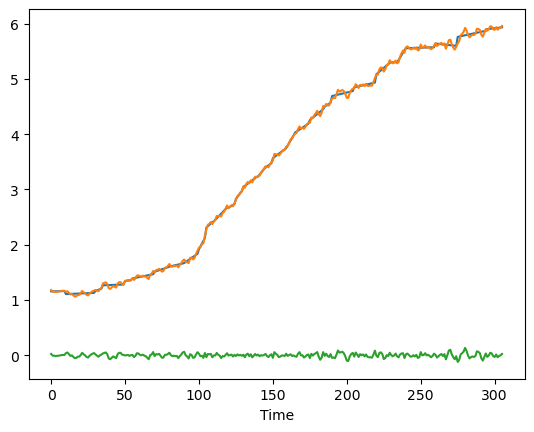

In [124]:
(UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing-detrended_data).plot()
UKESM_ssp585_ts.ismip6shelfMelt_3dThermalForcing.plot()
detrended_data.plot()

Initial runs: 6 deterministic runs:

| Experiment       | Scenario        | Description                | Bias Correction Used |
|------------------|-----------------|----------------------------|----------------------|
| Control          | No Emissions    | Control. No thermal trend  | $\delta T$ ISMIP6    |
| UKESM SSP126     | Low Emissions   | Based on SSP126 scenario   | $\delta T$ ISMIP6    |
| UKESM SSP585     | High Emissions  | Based on SSP585 scenario   | $\delta T$ ISMIP6    |
| Control          | No Emissions    | Control. No thermal trend  | Paolo23 Sat. Obs.    |
| UKESM SSP126     | Low Emissions   | Based on SSP126 scenario   | Paolo23 Sat. Obs.    |
| UKESM SSP585     | High Emissions  | Based on SSP585 scenario   | Paolo23 Sat. Obs.    |
